In [1]:
import platform
import os

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from Detector_Classes.M3RefTracking import M3RefTracking
from Detector_Classes.DetectorConfigLoader import DetectorConfigLoader
from Detector_Classes.DreamDetector import DreamDetector

from det_classes_test import plot_ray_hits_2d, align_dream, get_residuals, get_efficiency, get_residuals_subdets_with_err, get_rays_in_sub_det_vectorized, get_rays_in_sub_det, get_raw_residuals, get_circle_scan, plot_2D_circle_scan

In [2]:
# Check if platform is Windows or Linux
if platform.system() == 'Windows':
    base_dir = 'F:/Saclay/cosmic_data/'
    det_type_info_dir = 'C:/Users/Dylan/PycharmProjects/Cosmic_Bench_DAQ_Control/config/detectors/'
    out_dir = 'F:/Saclay/Analysis/Cosmic Bench/11-5-24/'
    chunk_size = 100  # Number of files to process at once
elif platform.system() == 'Linux' and platform.node() == 'dylan-MS-7C84':
    base_dir = '/media/ucla/Saclay/cosmic_data/'
    det_type_info_dir = '/home/dylan/PycharmProjects/Cosmic_Bench_DAQ_Control/config/detectors/'
    out_dir = '/media/ucla/Saclay/Analysis/Cosmic Bench/11-5-24/'
    chunk_size = 100  # Number of files to process at once
elif platform.system() == 'Linux' and platform.node() == 'dphnpct50.extra.cea.fr':
    base_dir = '/local/home/dn277127/Bureau/cosmic_data/'
    det_type_info_dir = '/local/home/dn277127/PycharmProjects/Cosmic_Bench_DAQ_Control/config/detectors/'
    out_dir = '/local/home/dn277127/Bureau/cosmic_data/Analysis/11-15-24/'
    chunk_size = 7  # Number of files to process at once
else:
    raise OSError('Unknown platform')

run_name = 'urw_stats_10-31-24'
run_dir = f'{base_dir}{run_name}/'
sub_run_name = 'long_run'

det_single = 'asacusa_strip_2'

# file_nums = list(range(0, 6))
file_nums = 'all'

noise_sigma = 10

realign_dream = True  # If False, read alignment from file, if True, realign Dream detector

run_json_path = f'{run_dir}run_config.json'
data_dir = f'{run_dir}{sub_run_name}/filtered_root/'
ped_dir = f'{run_dir}{sub_run_name}/decoded_root/'
m3_dir = f'{run_dir}{sub_run_name}/m3_tracking_root/'
alignment_dir = f'{run_dir}alignments/'

z_align_range = [5, 5]  # mm range to search for optimal z position

try:
    os.mkdir(alignment_dir)
except FileExistsError:
    pass
try:
    os.mkdir(out_dir)
except FileExistsError:
    pass

In [3]:
print(f'Getting ray data...')
ray_data = M3RefTracking(m3_dir, single_track=True, file_nums=file_nums)

Getting ray data...


100%|██████████| 237/237 [00:23<00:00, 10.27it/s]


In [4]:
det_config_loader = DetectorConfigLoader(run_json_path, det_type_info_dir)

In [5]:
det_config = det_config_loader.get_det_config(det_single, sub_run_name=sub_run_name)
det = DreamDetector(config=det_config)
print(f'FEU Num: {det.feu_num}')
print(f'FEU Channels: {det.feu_connectors}')
print(f'HV: {det.hv}')
det.load_dream_data(data_dir, ped_dir, noise_sigma, file_nums, chunk_size, save_waveforms=False)
print(f'Hits shape: {det.dream_data.hits.shape}')

FEU Num: 4
FEU Channels: [1, 2, 3, 4]
HV: {'drift': 800, 'resist_1': 450, 'resist_2': 450}
Reading in data...


100%|██████████| 100/100 [00:22<00:00,  4.54it/s]


Read in data shape: (217821, 256, 32)
Getting amplitudes...


100%|██████████| 15/15 [00:03<00:00,  4.57it/s]


Fitting time: 3.5986685752868652 s
Processed sub-chunk 1/1
Processed chunk 1/3


100%|██████████| 100/100 [00:21<00:00,  4.67it/s]


Read in data shape: (219796, 256, 32)
Getting amplitudes...


100%|██████████| 15/15 [00:03<00:00,  4.52it/s]


Fitting time: 4.131727933883667 s
Processed sub-chunk 1/1
Processed chunk 2/3


100%|██████████| 37/37 [00:08<00:00,  4.18it/s]


Read in data shape: (81718, 256, 32)
Getting amplitudes...


100%|██████████| 15/15 [00:01<00:00, 13.09it/s]


Fitting time: 1.9116833209991455 s
Processed sub-chunk 1/1
Processed chunk 3/3
Getting hits...
Hits shape: (519335, 256)


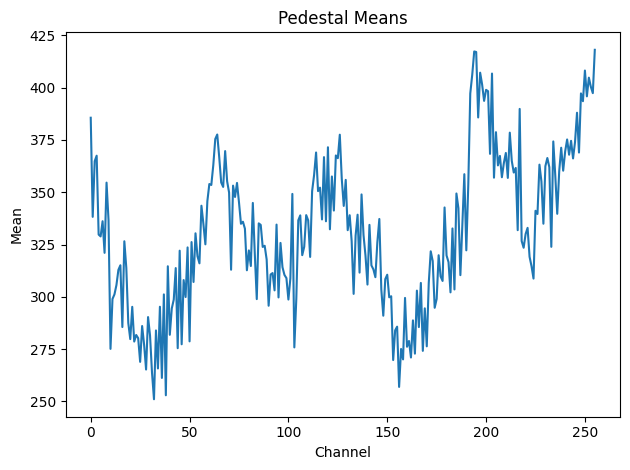

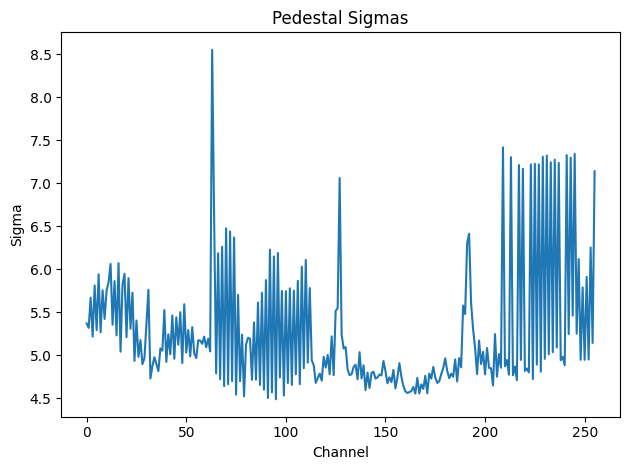

In [6]:
det.dream_data.plot_pedestals()

/home/dylan/PycharmProjects/saclay_micromegas/Detector_Classes/DreamData.py:699: RuntimeWarning: invalid value encountered in divide
  max_amp_div_sum = event_max_amps / event_amp_sums


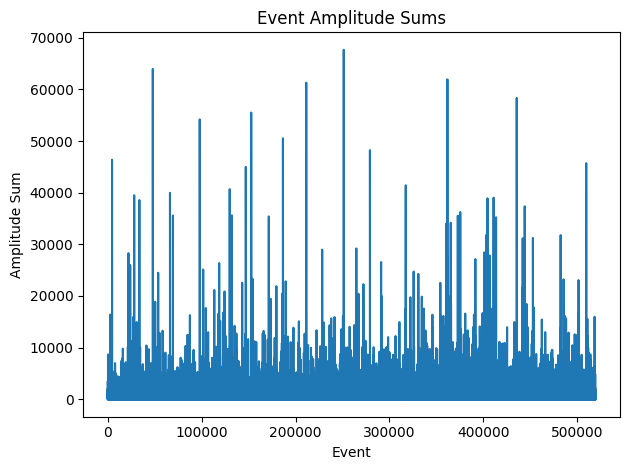

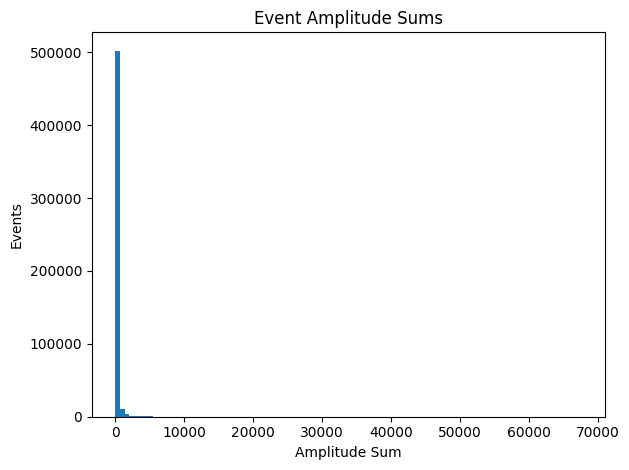

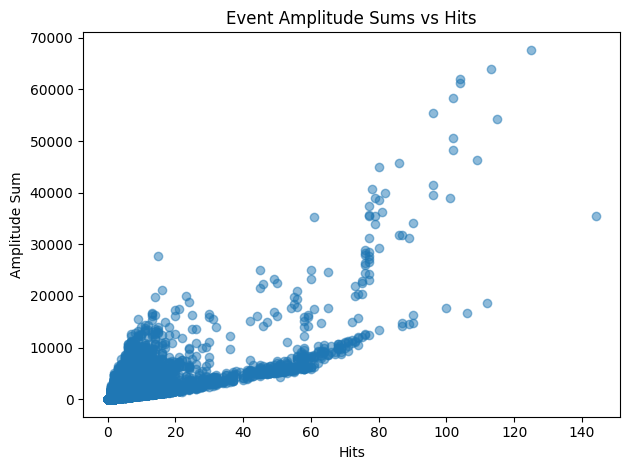

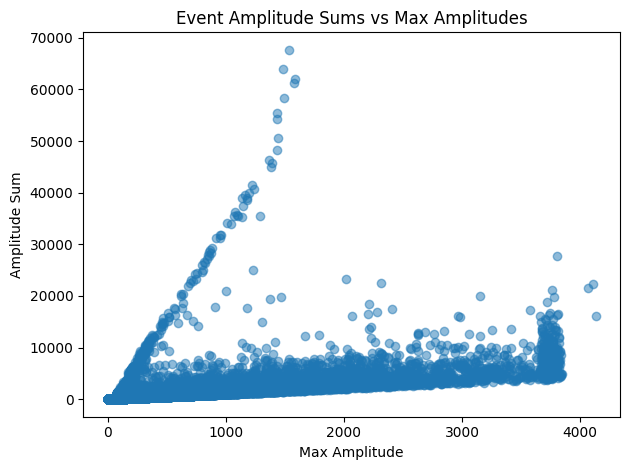

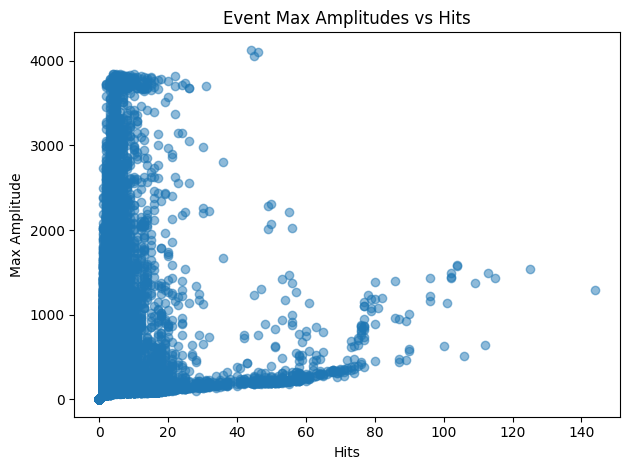

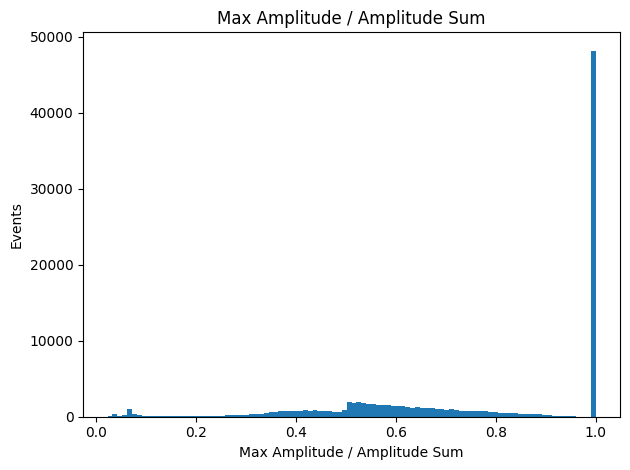

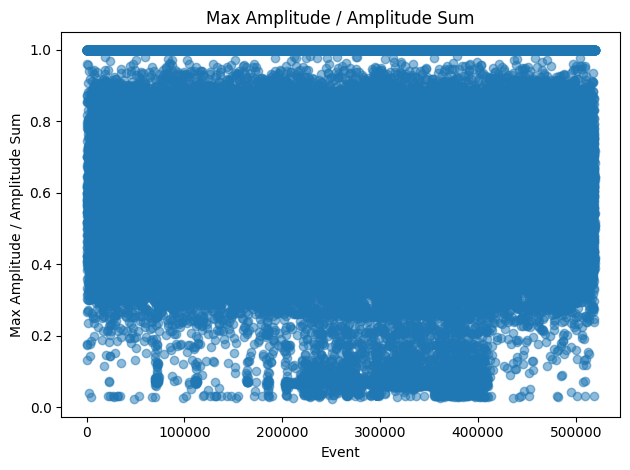

In [7]:
det.dream_data.plot_noise_metric()

Connector 1 Dead Strips: []
Connector 2 Dead Strips: [64 70]
Connector 3 Dead Strips: []
Connector 4 Dead Strips: []


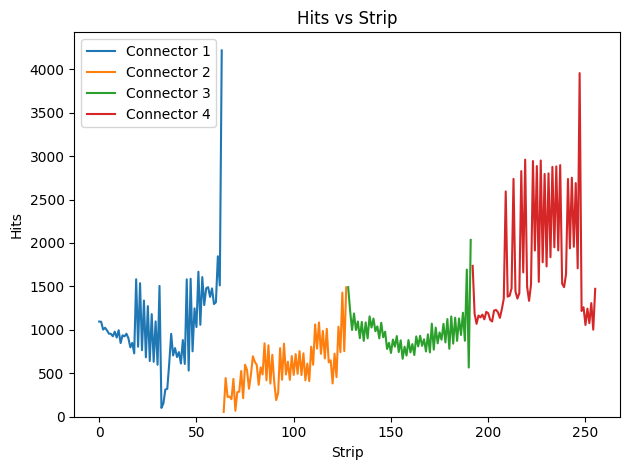

In [8]:
det.dream_data.plot_hits_vs_strip(print_dead_strips=True)

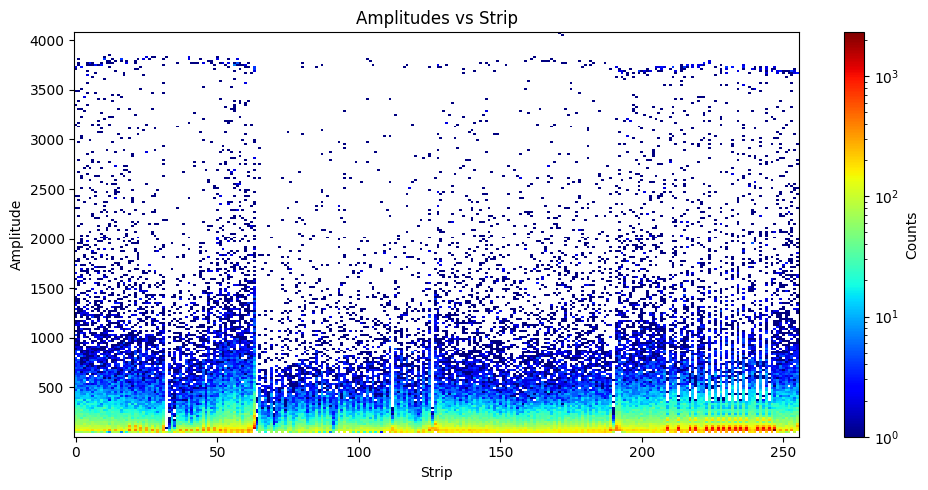

In [9]:
det.dream_data.plot_amplitudes_vs_strip()

/home/dylan/PycharmProjects/saclay_micromegas/Detector_Classes/DreamDetector.py:615: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.tight_layout()
/home/dylan/PycharmProjects/saclay_micromegas/venv/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/home/dylan/PycharmProjects/saclay_micromegas/venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


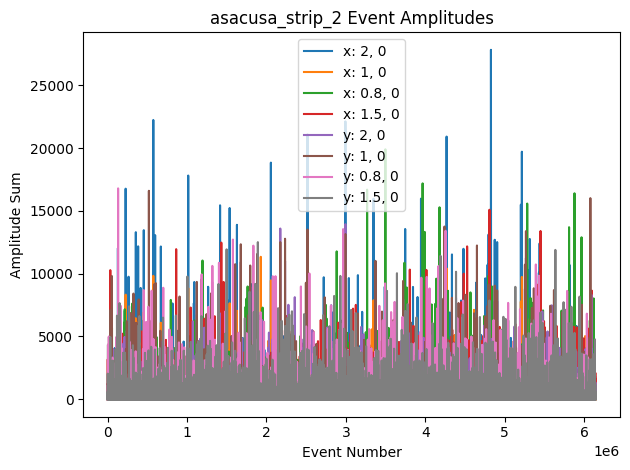

In [10]:
det.make_sub_detectors()
event_nums = det.plot_xy_amp_sum_vs_event_num(True, 500, False, 15)

if realign_dream:
    det.add_rotation(90, 'z')

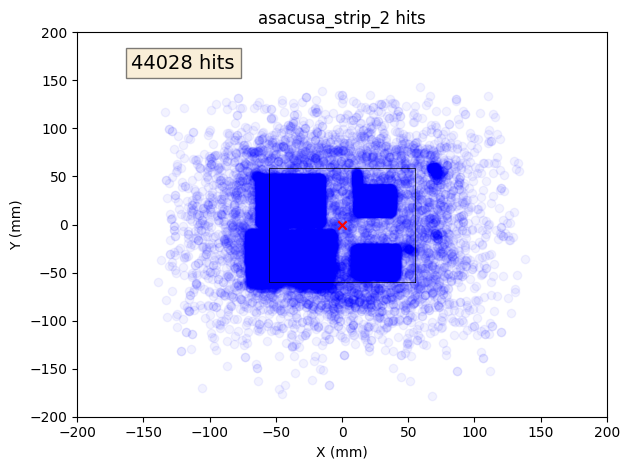

In [11]:
plot_ray_hits_2d(det, ray_data)

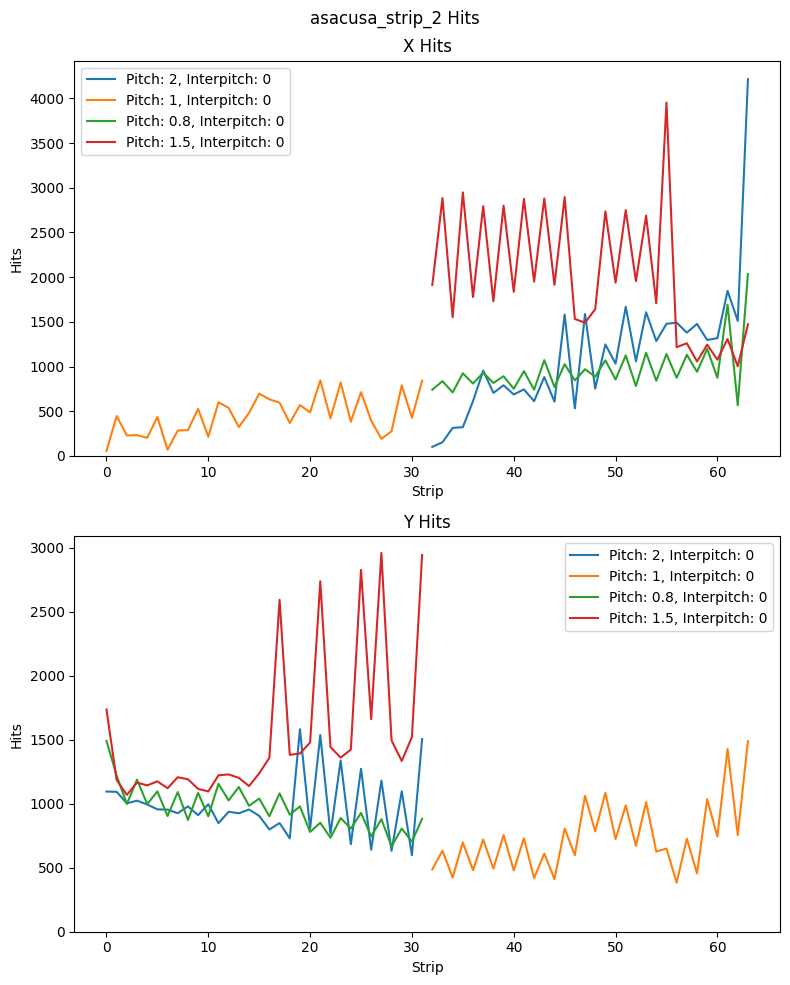

In [12]:
det.plot_hits_1d()

In [13]:
print(len(det.dream_data.hits))

519335


In [14]:
# for event_num in range(min(len(det.dream_data.hits), 2)):
#     det.plot_event_1d(event_num)
#     det.plot_event_2d(event_num)
#     det.dream_data.plot_waveforms(event_num)

z: 503.0
z: 503.3448275862069
z: 503.6896551724138
z: 504.0344827586207
z: 504.37931034482756
z: 504.7241379310345
z: 505.0689655172414
z: 505.41379310344826
z: 505.7586206896552
z: 506.1034482758621
z: 506.44827586206895
z: 506.7931034482759
z: 507.13793103448273
z: 507.48275862068965
z: 507.82758620689657
z: 508.17241379310343
z: 508.51724137931035
z: 508.86206896551727
z: 509.2068965517241
z: 509.55172413793105
z: 509.8965517241379
z: 510.2413793103448
z: 510.58620689655174
z: 510.9310344827586
z: 511.2758620689655
z: 511.62068965517244
z: 511.9655172413793
z: 512.3103448275862
z: 512.6551724137931
z: 513.0
z_rot: -1.0
z_rot: -0.9310344827586207
z_rot: -0.8620689655172413
z_rot: -0.7931034482758621
z_rot: -0.7241379310344828
z_rot: -0.6551724137931034
z_rot: -0.5862068965517242
z_rot: -0.5172413793103449
z_rot: -0.4482758620689655
z_rot: -0.3793103448275862
z_rot: -0.31034482758620685
z_rot: -0.24137931034482762
z_rot: -0.1724137931034483
z_rot: -0.10344827586206895
z_rot: -0.034482

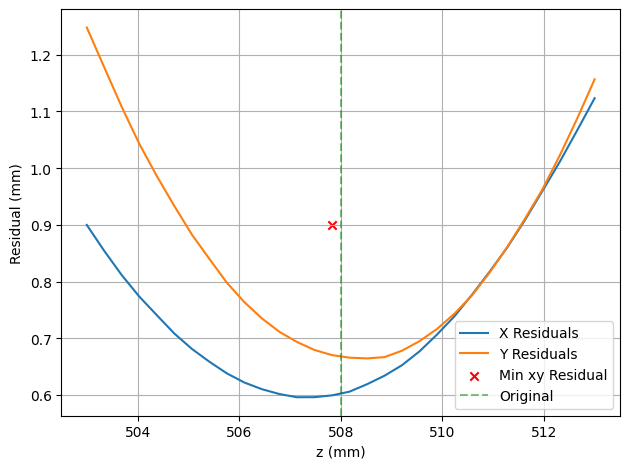

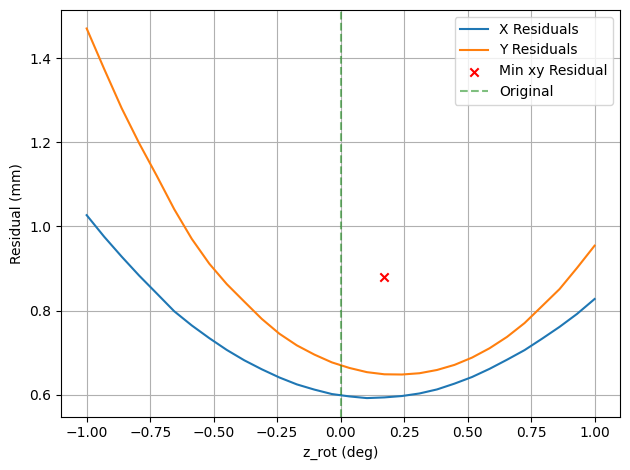

In [15]:
z_orig = det.center[2]
x_bnds = det.center[0] - det.size[0] / 2, det.center[0] + det.size[0] / 2
y_bnds = det.center[1] - det.size[1] / 2, det.center[1] + det.size[1] / 2
ray_traversing_triggers = ray_data.get_traversing_triggers(z_orig, x_bnds, y_bnds, expansion_factor=0.1)

alignment_file = f'{alignment_dir}{det.name}_alignment.txt'
if realign_dream:
    align_dream(det, ray_data, z_align_range)
    det.write_det_alignment_to_file(alignment_file)
else:
    det.read_det_alignment_from_file(alignment_file)

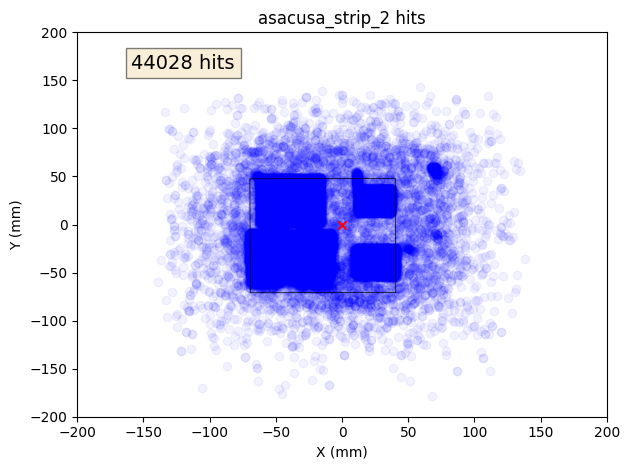

In [16]:
plot_ray_hits_2d(det, ray_data)

Pre-filtered rays: 1630227
All rays: 350368


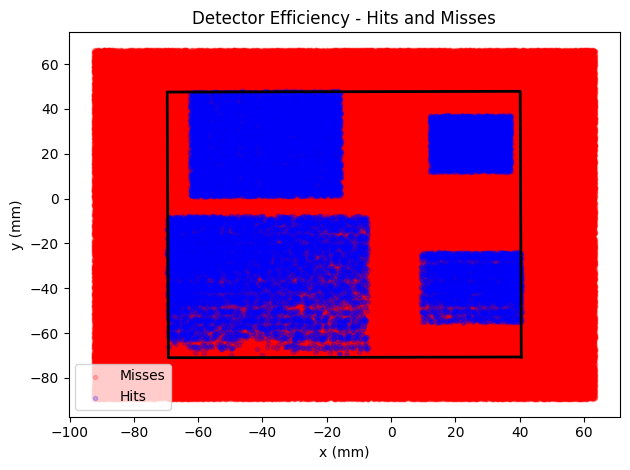

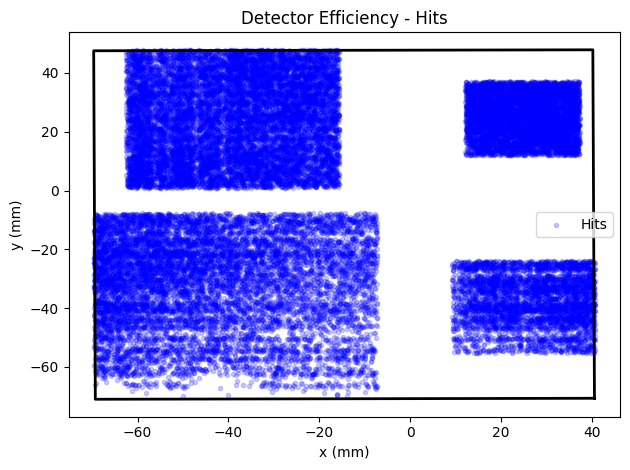

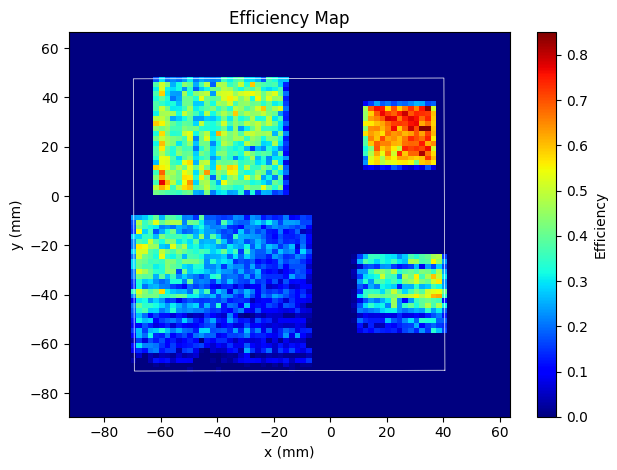

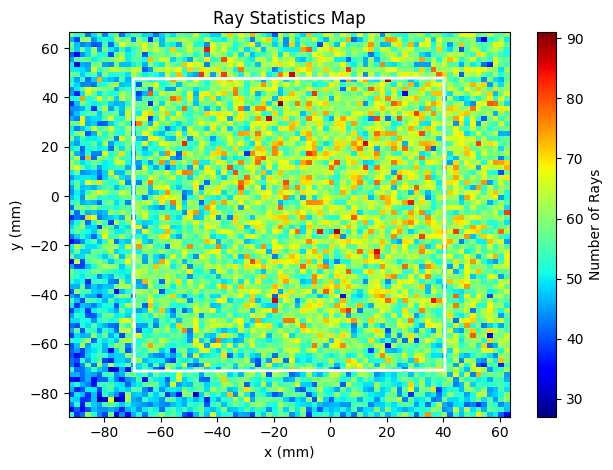

In [17]:
get_efficiency(det, ray_data, plot=True, in_det=True, tolerance=0.2, grid_size=2)

/home/dylan/PycharmProjects/saclay_micromegas/poc/det_classes_test.py:1460: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.tight_layout()


X Residuals: Mean=45μm, Std=756μm
Y Residuals: Mean=207μm, Std=684μm
X Residuals: Mean=86μm, Std=457μm
Y Residuals: Mean=46μm, Std=484μm
X Residuals: Mean=-13μm, Std=374μm
Y Residuals: Mean=-42μm, Std=435μm
X Residuals: Mean=-43μm, Std=650μm
Y Residuals: Mean=-193μm, Std=800μm


(0.0047269456457183475,
 0.02481829829834918,
 0.5381091695270818,
 0.6179876745827514)

/home/dylan/PycharmProjects/saclay_micromegas/venv/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/home/dylan/PycharmProjects/saclay_micromegas/venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


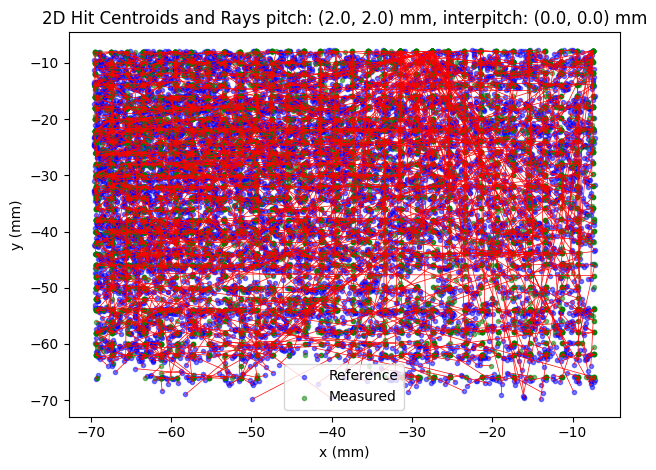

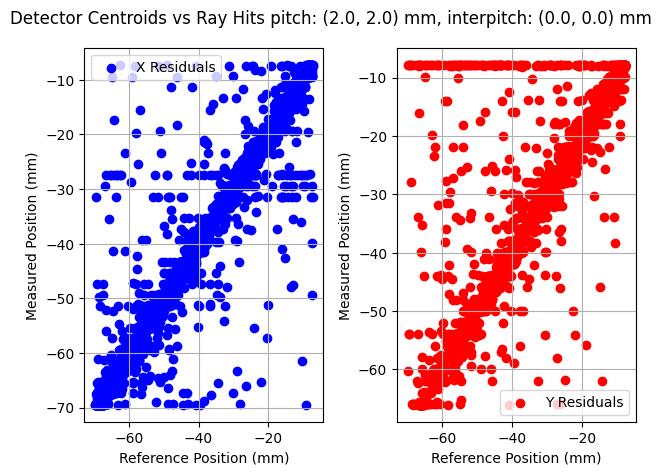

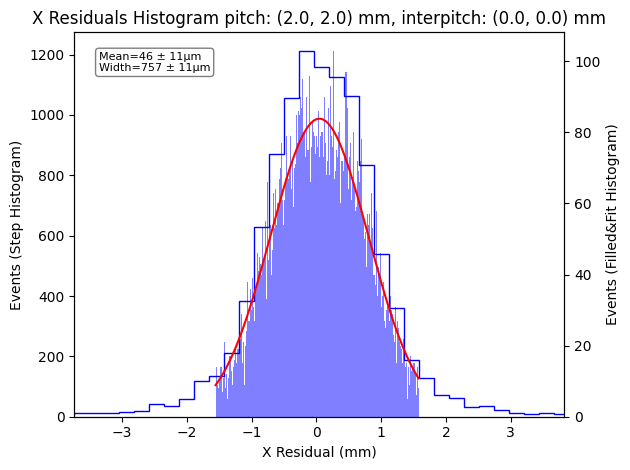

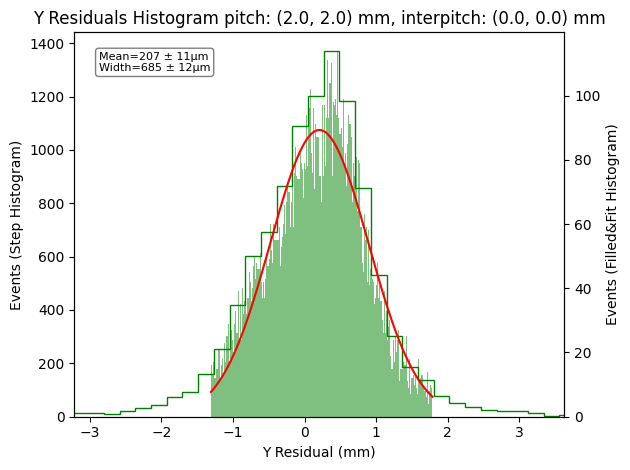

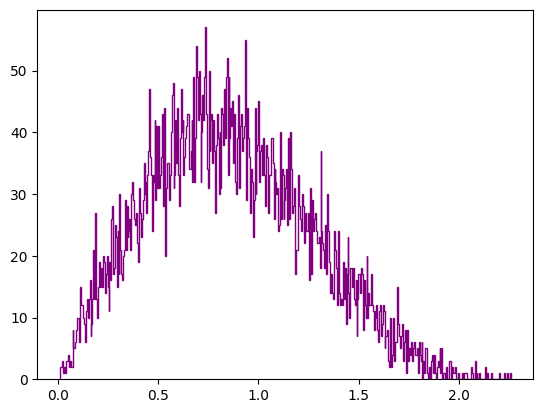

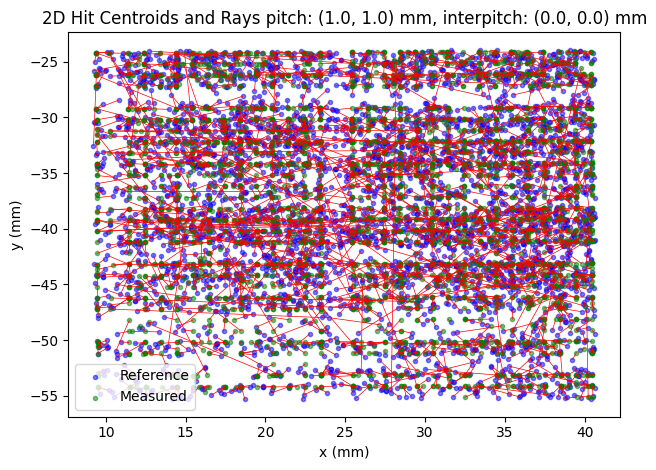

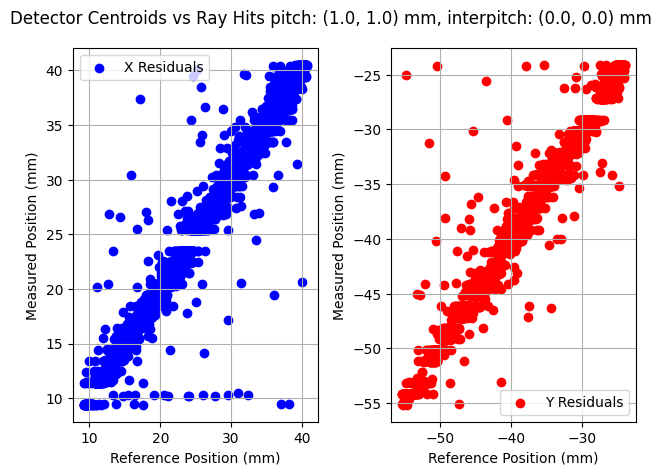

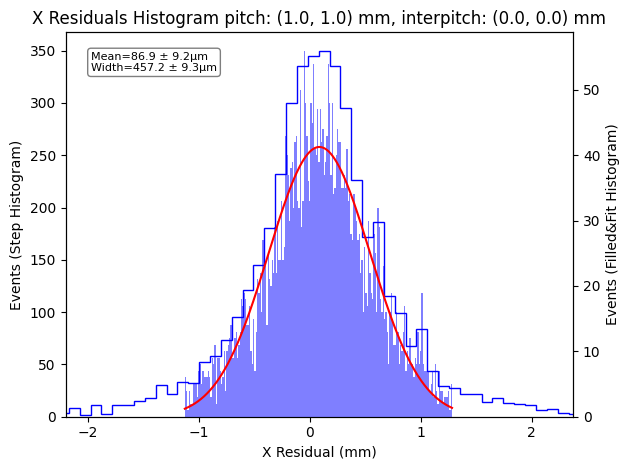

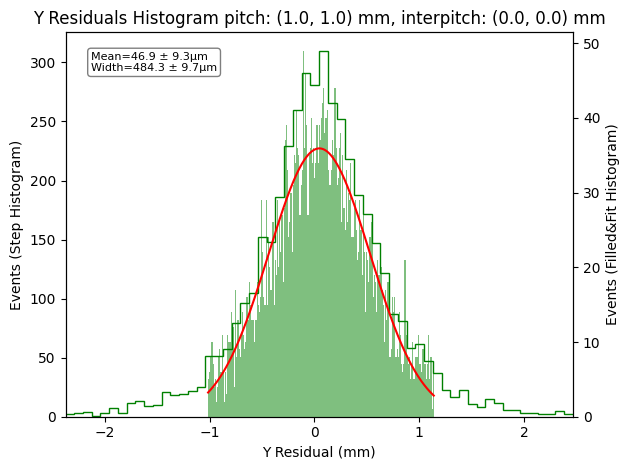

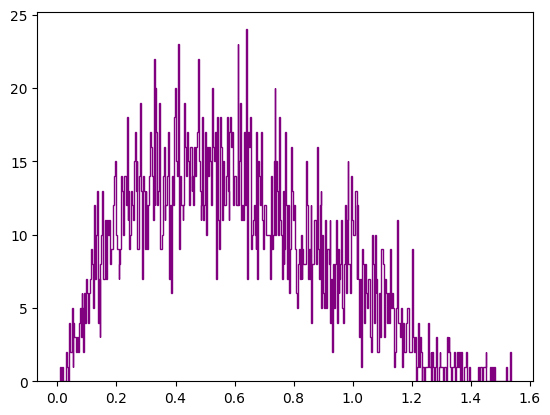

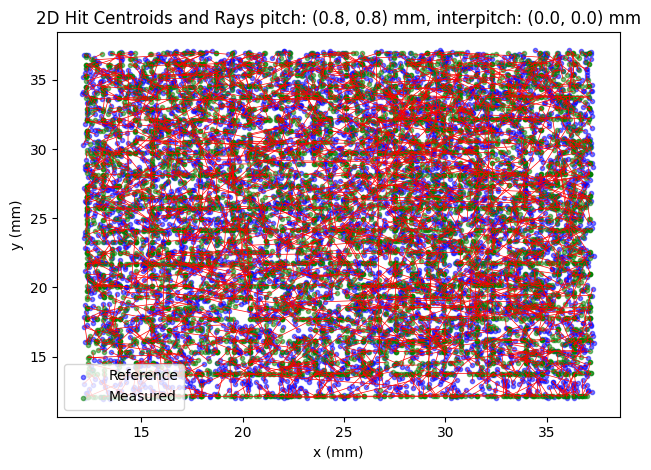

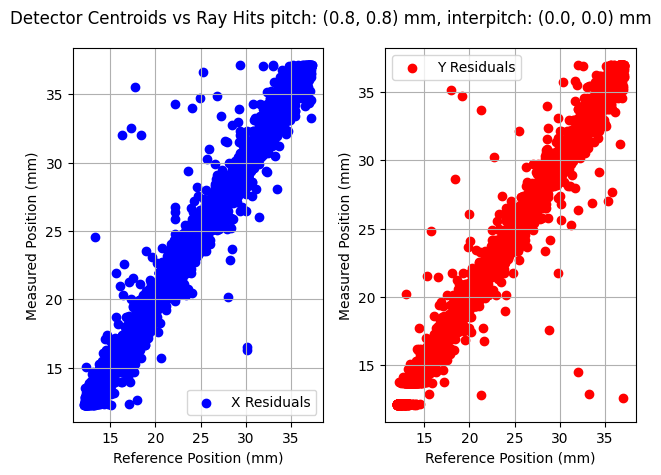

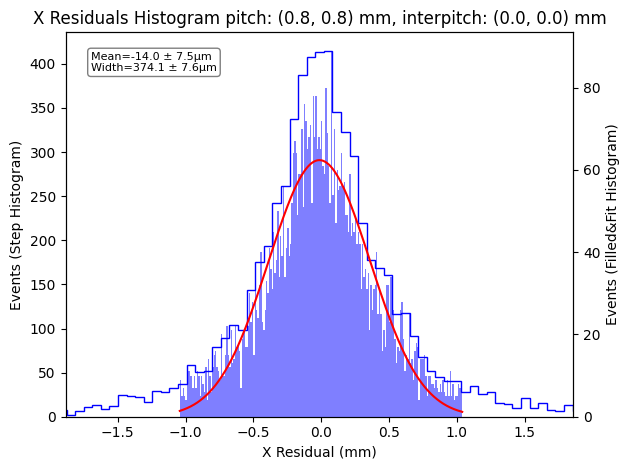

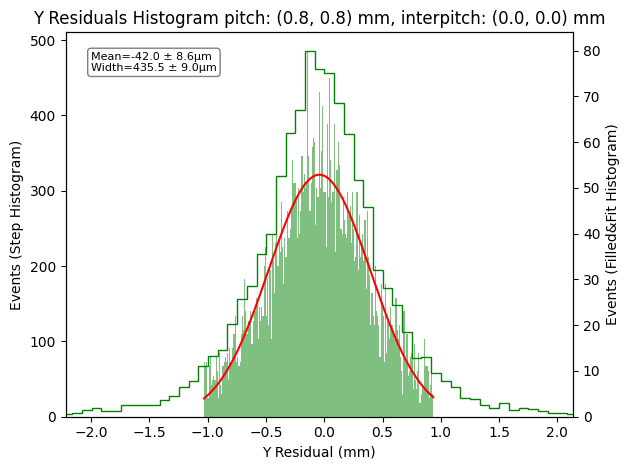

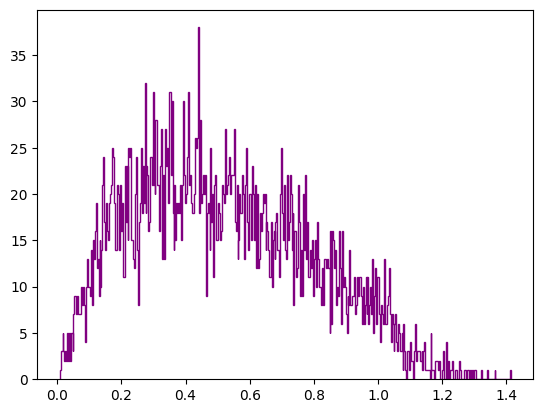

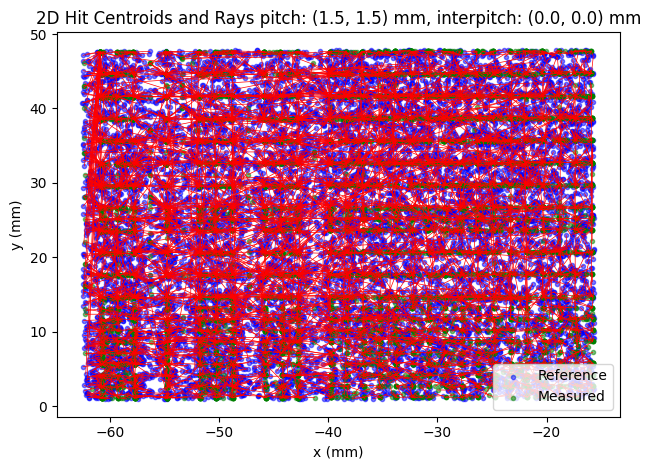

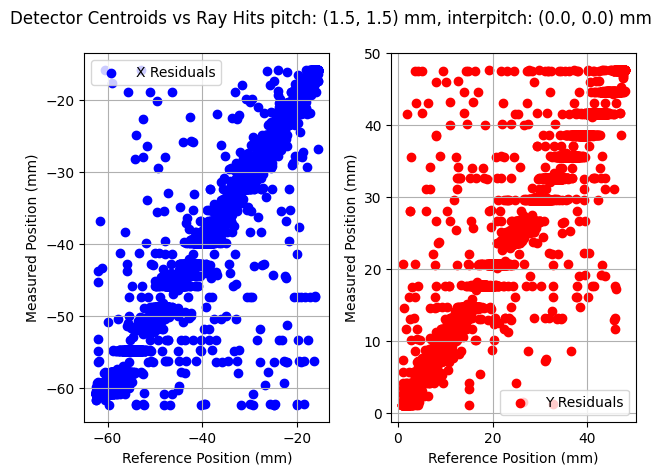

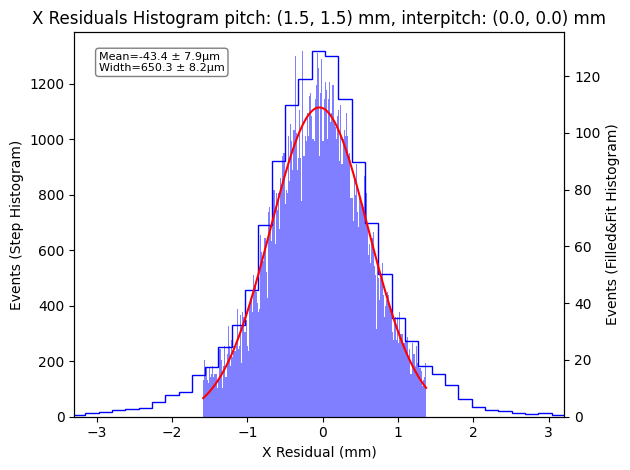

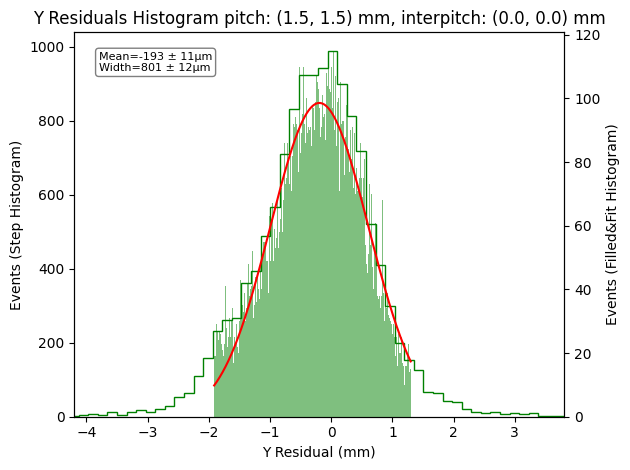

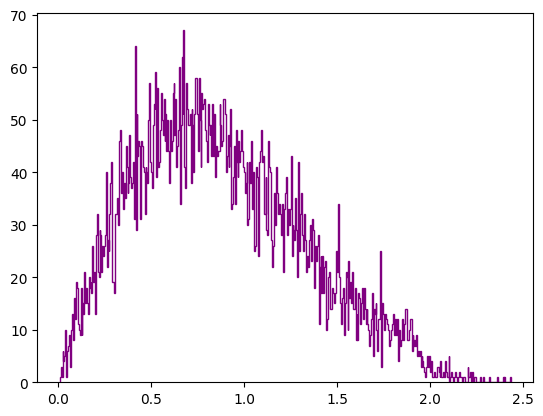

In [18]:
get_residuals(det, ray_data, plot=True, in_det=True, tolerance=0.2)

In [19]:
sub_resids = get_residuals_subdets_with_err(det, ray_data, in_det=True, tolerance=0.2)

   pitch_x  pitch_y  interpitch_x  interpitch_y    x_mean  x_mean_err  \
0      2.0      2.0           0.0           0.0  0.045766    0.010601   
1      1.0      1.0           0.0           0.0  0.086887    0.009226   
2      0.8      0.8           0.0           0.0 -0.013998    0.007527   
3      1.5      1.5           0.0           0.0 -0.043397    0.007938   

     y_mean  y_mean_err     x_std  x_std_err     y_std  y_std_err  
0  0.684931    0.011674  0.756800   0.011345  0.684931   0.011674  
1  0.484324    0.009714  0.457172   0.009314  0.484324   0.009714  
2  0.435520    0.008972  0.374055   0.007565  0.435520   0.008972  
3  0.800769    0.012251  0.650275   0.008237  0.800769   0.012251  


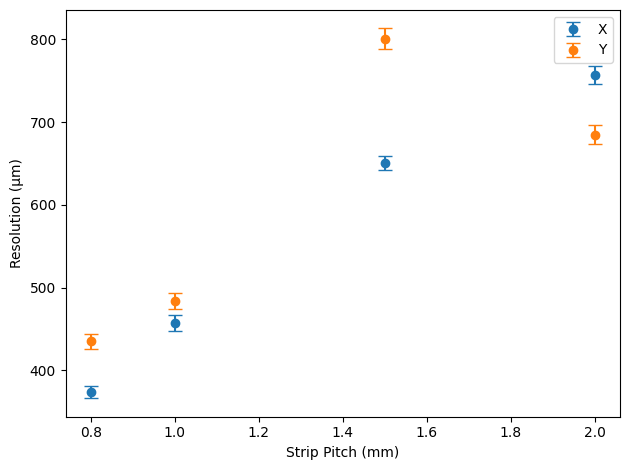

In [20]:
sub_resids = pd.DataFrame(sub_resids)
print(sub_resids)
fig, ax = plt.subplots()
ax.errorbar(sub_resids['pitch_x'], sub_resids['x_std'] * 1e3, yerr=sub_resids['x_std_err'] * 1e3, fmt='o', capsize=5, label='X')
ax.errorbar(sub_resids['pitch_x'], sub_resids['y_std'] * 1e3, yerr=sub_resids['y_std_err'] * 1e3, fmt='o', capsize=5, label='Y')
ax.legend()
ax.set_xlabel('Strip Pitch (mm)')
ax.set_ylabel('Resolution (μm)')
fig.tight_layout()

   pitch_x  pitch_y  interpitch_x  interpitch_y    x_mean  x_mean_err  \
0      2.0      2.0           0.0           0.0  0.049852    0.012495   
1      1.0      1.0           0.0           0.0  0.084724    0.009194   
2      0.8      0.8           0.0           0.0 -0.014374    0.006819   
3      1.5      1.5           0.0           0.0 -0.041104    0.008402   

     y_mean  y_mean_err     x_std  x_std_err     y_std  y_std_err  
0  0.681196    0.016049  0.765102   0.016361  0.681196   0.016049  
1  0.462863    0.010610  0.439260   0.009683  0.462863   0.010610  
2  0.424837    0.008514  0.365192   0.006966  0.424837   0.008514  
3  0.762580    0.012802  0.617737   0.009542  0.762580   0.012802  


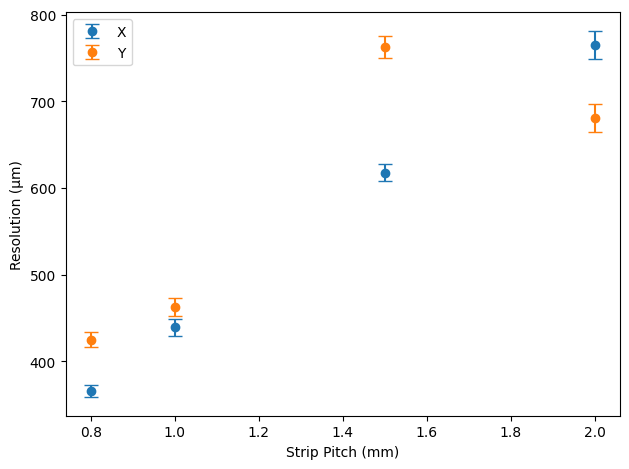

In [21]:
sub_resids = get_residuals_subdets_with_err(det, ray_data, in_det=True, tolerance=0.2, max_r=2)
sub_resids = pd.DataFrame(sub_resids)
print(sub_resids)
fig, ax = plt.subplots()
ax.errorbar(sub_resids['pitch_x'], sub_resids['x_std'] * 1e3, yerr=sub_resids['x_std_err'] * 1e3, fmt='o', capsize=5, label='X')
ax.errorbar(sub_resids['pitch_x'], sub_resids['y_std'] * 1e3, yerr=sub_resids['y_std_err'] * 1e3, fmt='o', capsize=5, label='Y')
ax.legend()
ax.set_xlabel('Strip Pitch (mm)')
ax.set_ylabel('Resolution (μm)')
fig.tight_layout()

New stuff above

   pitch_x  pitch_y  interpitch_x  interpitch_y    x_mean  x_mean_err  \
0      2.0      2.0           0.0           0.0  0.049852    0.012495   
1      1.0      1.0           0.0           0.0  0.084724    0.009194   
2      0.8      0.8           0.0           0.0 -0.014374    0.006819   
3      1.5      1.5           0.0           0.0 -0.041104    0.008402   

     y_mean  y_mean_err     x_std  x_std_err     y_std  y_std_err  
0  0.681196    0.016049  0.765102   0.016361  0.681196   0.016049  
1  0.462863    0.010610  0.439260   0.009683  0.462863   0.010610  
2  0.424837    0.008514  0.365192   0.006966  0.424837   0.008514  
3  0.762580    0.012802  0.617737   0.009542  0.762580   0.012802  


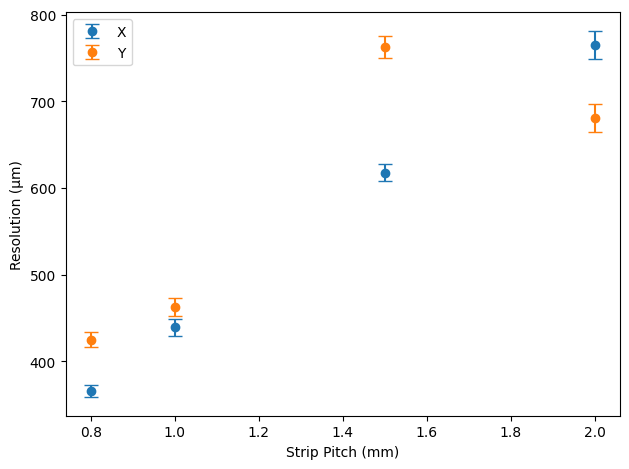

In [22]:
sub_resids = get_residuals_subdets_with_err(det, ray_data, in_det=True, tolerance=0.2, max_r=2)
sub_resids = pd.DataFrame(sub_resids)
print(sub_resids)
fig, ax = plt.subplots()
ax.errorbar(sub_resids['pitch_x'], sub_resids['x_std'] * 1e3, yerr=sub_resids['x_std_err'] * 1e3, fmt='o', capsize=5, label='X')
ax.errorbar(sub_resids['pitch_x'], sub_resids['y_std'] * 1e3, yerr=sub_resids['y_std_err'] * 1e3, fmt='o', capsize=5, label='Y')
ax.legend()
ax.set_xlabel('Strip Pitch (mm)')
ax.set_ylabel('Resolution (μm)')
fig.tight_layout()

Rays in sub-detector 0: 48773, total rays: 1630227
Rays in sub-detector 1: 11108, total rays: 1630227
Rays in sub-detector 2: 6855, total rays: 1630227
Rays in sub-detector 3: 27183, total rays: 1630227


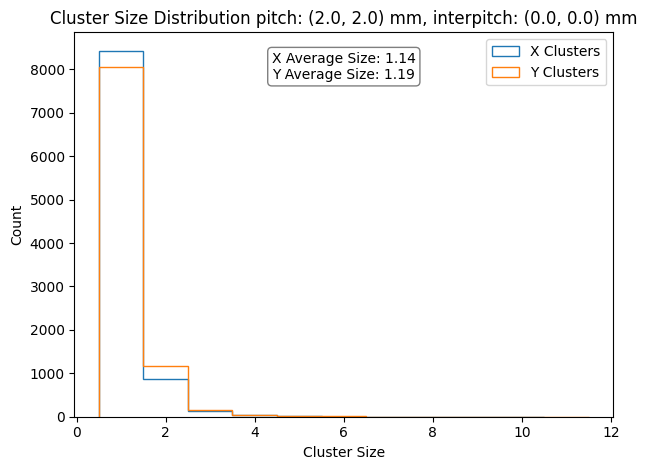

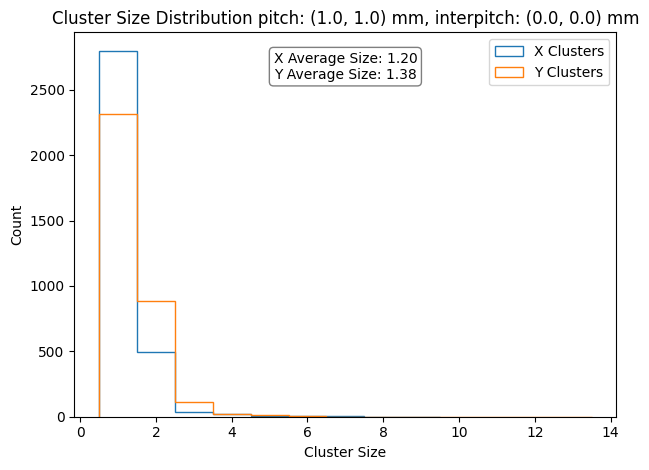

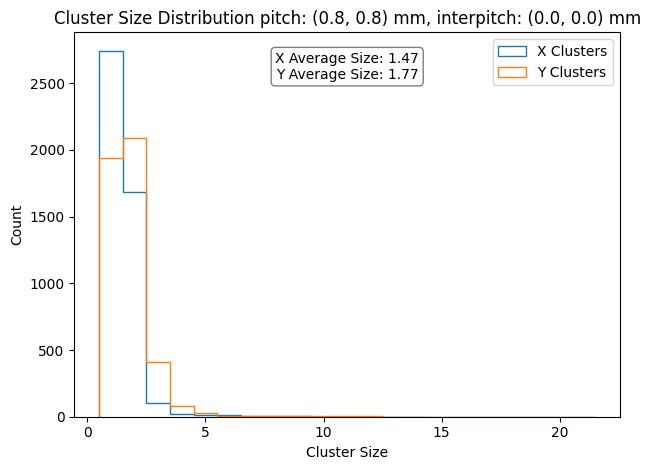

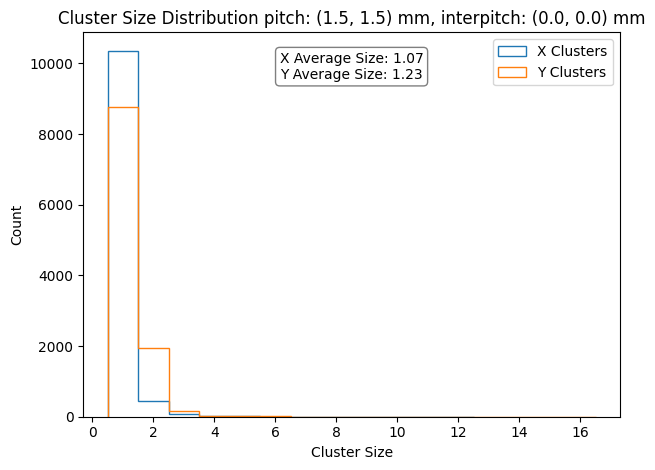

In [23]:
x_rays, y_rays, event_num_rays = ray_data.get_xy_positions(det.center[2])
pitches, x_means, x_errs, y_means, y_errs = [], [], [], [], []
for sub_det in det.sub_detectors:
    x_rays_in, y_rays_in, event_num_rays_in = get_rays_in_sub_det_vectorized(det, det.sub_detectors[sub_det.sub_index], x_rays, y_rays, event_num_rays, tolerance=-2)
    print(f'Rays in sub-detector {sub_det.sub_index}: {len(x_rays_in)}, total rays: {len(x_rays)}')
    x_mean, y_mean, x_err, y_err = sub_det.plot_cluster_sizes(event_nums=event_num_rays_in)
    pitches.append(sub_det.x_pitch)
    x_means.append(x_mean)
    x_errs.append(x_err)
    y_means.append(y_mean)
    y_errs.append(y_err)

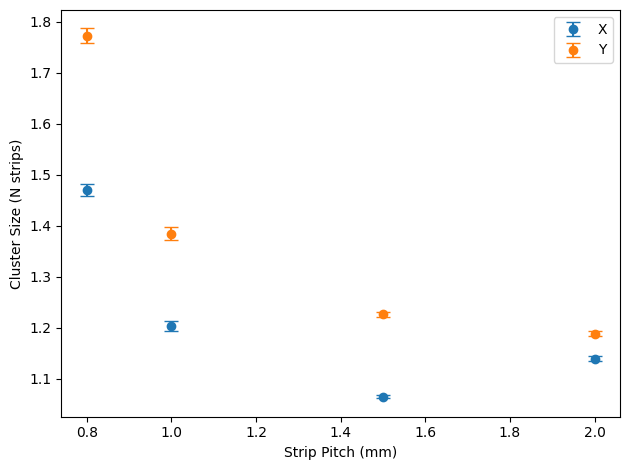

In [24]:
fig, ax = plt.subplots()
ax.errorbar(pitches, x_means, yerr=x_errs, fmt='o', capsize=5, label='X')
ax.errorbar(pitches, y_means, yerr=y_errs, fmt='o', capsize=5, label='Y')
ax.legend()
ax.set_xlabel('Strip Pitch (mm)')
ax.set_ylabel('Cluster Size (N strips)')
fig.tight_layout()

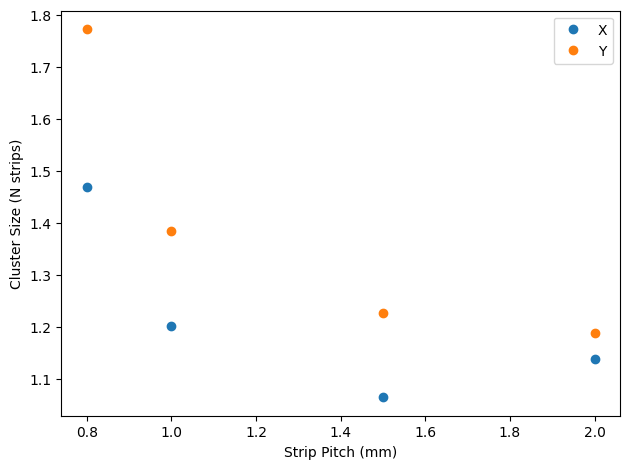

In [25]:
fig, ax = plt.subplots()
ax.plot(pitches, x_means, 'o', label='X')
ax.plot(pitches, y_means, 'o', label='Y')
ax.legend()
ax.set_xlabel('Strip Pitch (mm)')
ax.set_ylabel('Cluster Size (N strips)')
fig.tight_layout()

In [26]:
x_res, y_res, x_rays, y_rays = get_raw_residuals(det, ray_data, in_det=True, tolerance=0.0)

scan_res min: 0.2062567084477081, max: 1.281035737658786
res_vmax: 1.1073759948934878
mean_vmin: -0.29899573174662714, mean_vmax: 0.2049321789376394


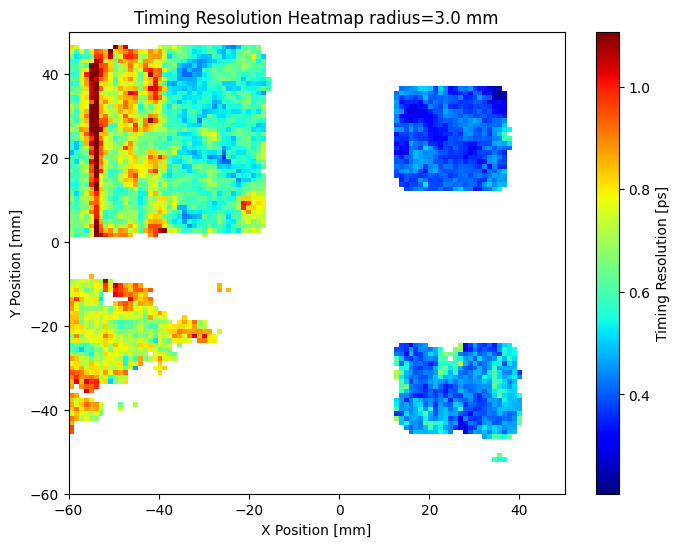

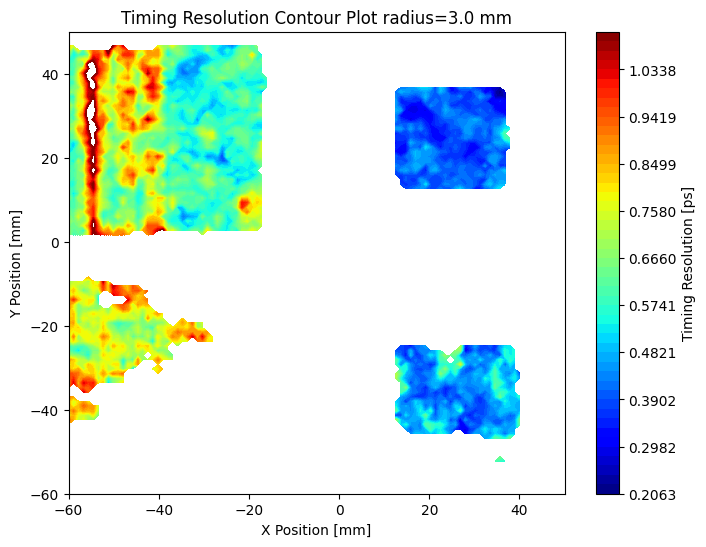

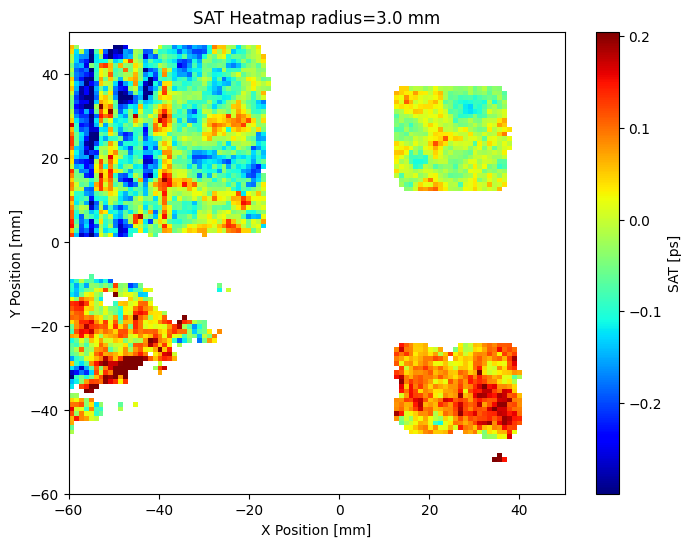

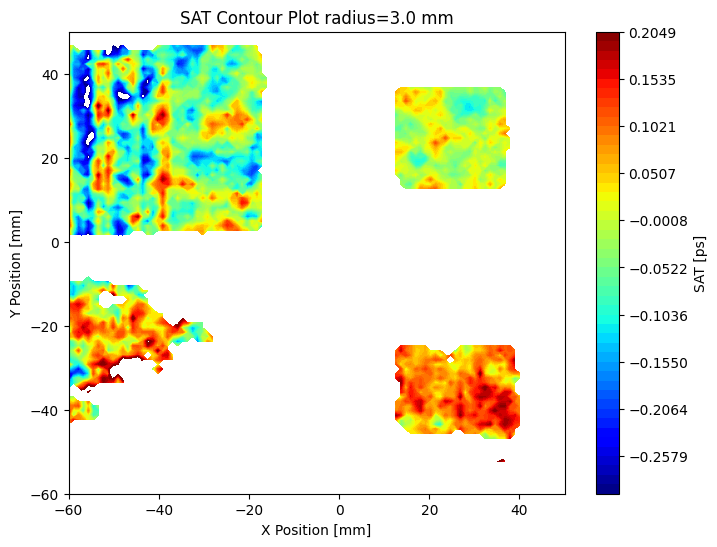

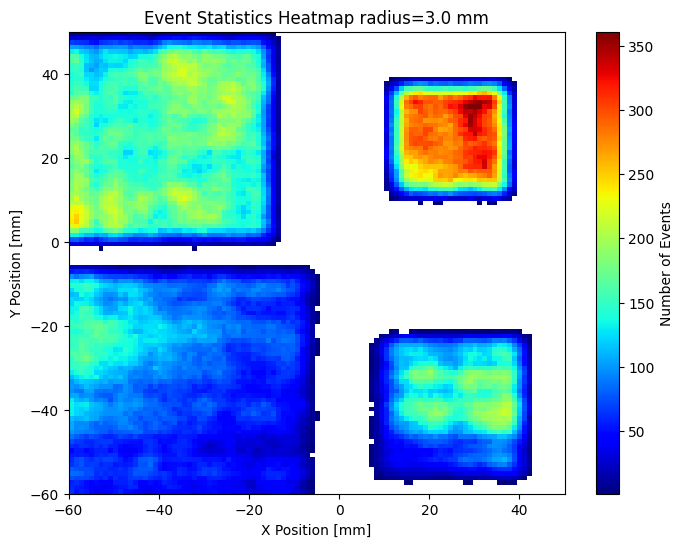

In [27]:
scan_xs = np.linspace(-60, 50, 100 + 1)
scan_ys = np.linspace(-60, 50, 100 + 1)

# Generate mesh grid
x_mesh, y_mesh = np.meshgrid(scan_xs, scan_ys)
xy_pairs = list(zip(x_mesh.ravel(), y_mesh.ravel()))  # Flatten to list of (x, y) pairs
scan_radius = 3

scan_resolutions_x, scan_means_x, events_x = get_circle_scan(np.array(x_res), np.array(x_rays), np.array(y_rays), xy_pairs, radius=scan_radius, percentile_cuts=(1, 99), plot=False)
plot_2D_circle_scan(scan_resolutions_x, scan_means_x, scan_xs, scan_ys, scan_events=events_x, radius=scan_radius, percentile_filter=(1, 99))

scan_res min: 0.2746590051078498, max: 1.565077683089771
res_vmax: 1.2805213394836104
mean_vmin: -0.5677594476372185, mean_vmax: 0.3167971811135796


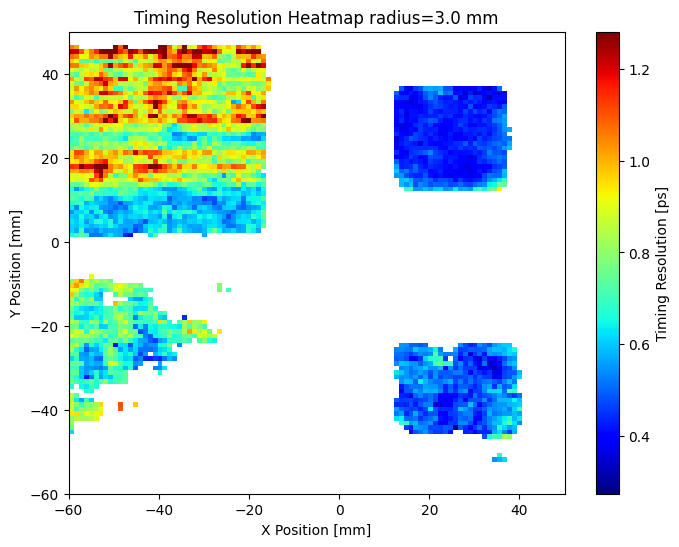

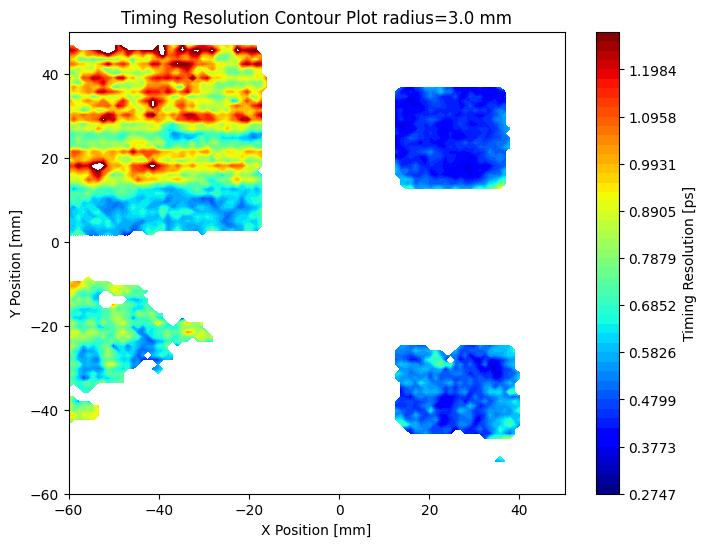

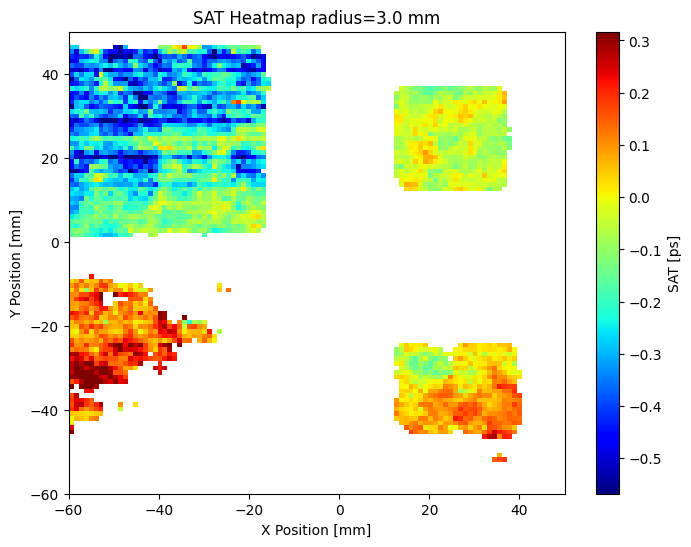

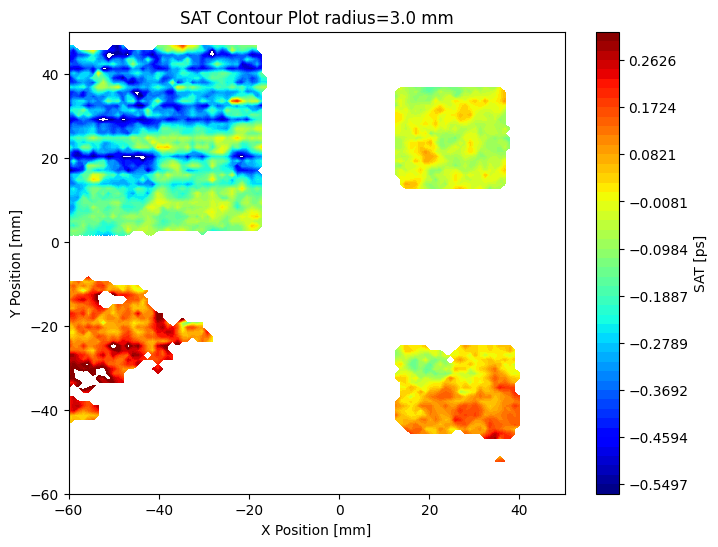

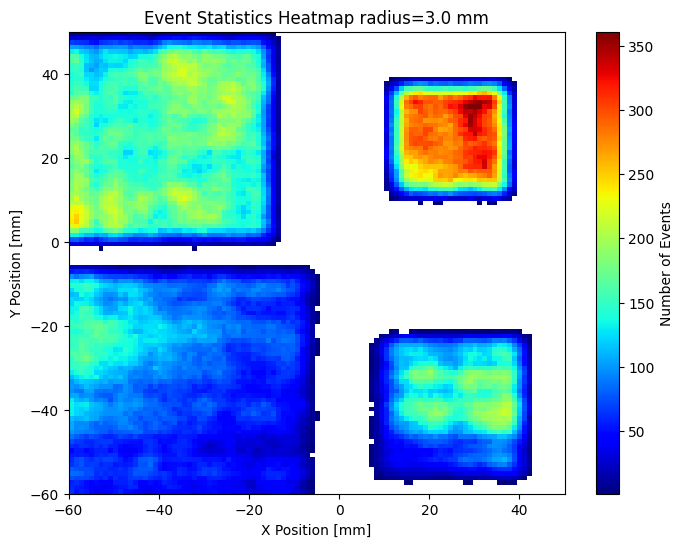

In [28]:
scan_resolutions_y, scan_means_y, events_y = get_circle_scan(np.array(y_res), np.array(x_rays), np.array(y_rays), xy_pairs, radius=scan_radius, percentile_cuts=(1, 99), plot=False)
plot_2D_circle_scan(scan_resolutions_y, scan_means_y, scan_xs, scan_ys, scan_events=events_y, radius=scan_radius, percentile_filter=(1, 99))